In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abidi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\abidi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\abidi\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

In [4]:
df = pd.read_csv("../Amazon-costumer-reviews/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Quick EDA

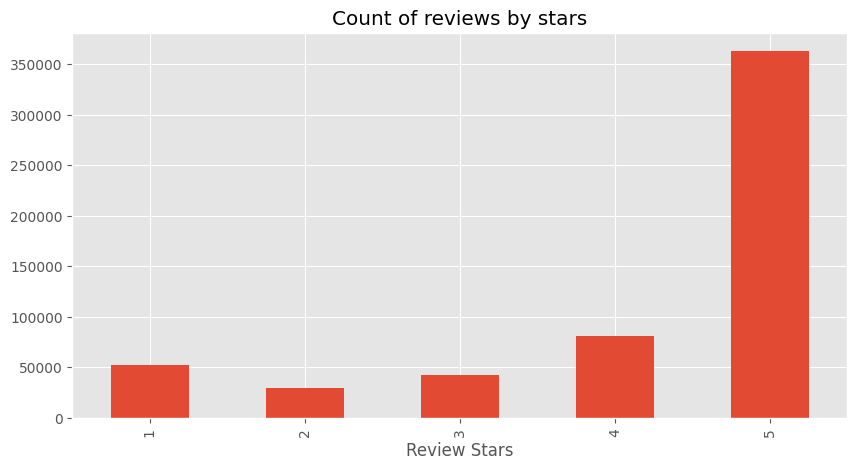

In [5]:
ax = df["Score"].value_counts().sort_index().plot(kind='bar', title='Count of reviews by stars' , figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [6]:
exp = df['Text'][50]
print(exp)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [7]:
tokens = nltk.word_tokenize(exp)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [8]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [9]:
nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\abidi\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## VADER( Valence Aware Dictionary for Sentiment Reasoning)
it's an NLTK module that provides sentiment scores based on the words used

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\abidi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [35]:
sia.polarity_scores('I want to kill my self ')

{'neg': 0.522, 'neu': 0.333, 'pos': 0.144, 'compound': -0.6597}

In [12]:
sia.polarity_scores(exp)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [13]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/568454 [00:00<?, ?it/s]

In [14]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={"index":'Id'})
vaders = vaders.merge(df,how='left')

In [15]:
# now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plot VADER results

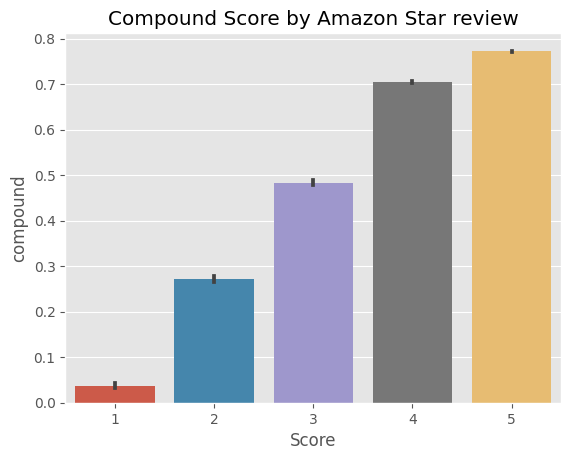

In [16]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score by Amazon Star review')
plt.show()

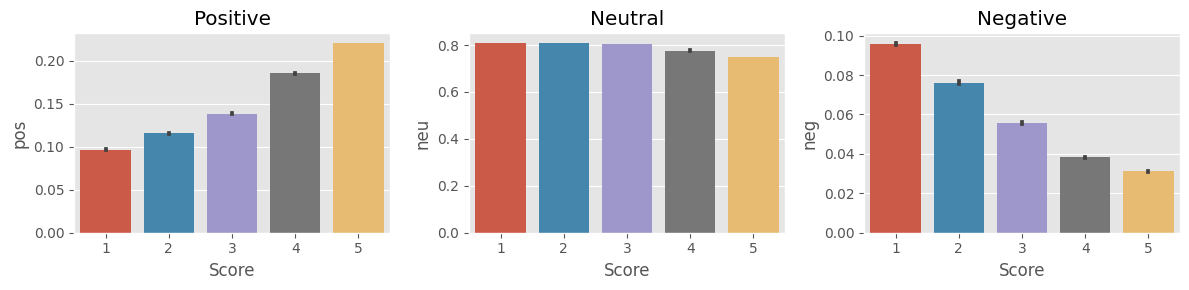

In [17]:
fig, axs = plt.subplots(1,3,figsize=(12,3))
sns.barplot(data=vaders , x='Score', y='pos' , ax = axs[0])
sns.barplot(data=vaders , x='Score', y='neu' , ax = axs[1])
sns.barplot(data=vaders , x='Score', y='neg' , ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

## Roberta Model

In [18]:
%pip install transformers

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [19]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [20]:
# VADER results on exemple
print(exp)
sia.polarity_scores(exp)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [21]:
# run for Roberta Model
encoded_text = tokenizer(exp,return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.02068747, 'roberta_pos': 0.0029573706}


In [22]:
def polarity_scores_roberta(exp):
  encoded_text = tokenizer(exp,return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
      'roberta_neg': scores[0],
      'roberta_neu': scores[1],
      'roberta_pos': scores[2]
  }
  return scores_dict

In [23]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  try:
    text = row['Text']
    myid = row['Id']
    vader_result = sia.polarity_scores(text)

    roberta_result = polarity_scores_roberta(text)
    both = {**vader_result,**roberta_result}
    res[myid] = both
    break
  except RuntimeError:
    continue
    print(f'Broke for id {myid}')

  0%|          | 0/568454 [00:00<?, ?it/s]

In [24]:
results_df = pd.DataFrame(res).T
results_df = vaders.reset_index().rename(columns={"index":'Id'})
results_df = vaders.merge(df,how='left')

In [25]:
type(results_df)
results_df.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Compare Scores between models

In [26]:
results_df.columns

Index(['Id', 'neg', 'neu', 'pos', 'compound', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

## Combine and Comprare

In [27]:
sns.pairplot(data=results_df,
             var=['vader_neg','vader_neu','vader_pos',
                  'roberta_neg','roberta_neu','roberta_pos'],
             hue='Score',
             palette='tab10')
plt.show()

TypeError: pairplot() got an unexpected keyword argument 'var'

In [ ]:
results_df.query('Score == 1') \
  .sort_values('roberta_pos', ascending=False)['Text'].values[0]

: 

### Negative sentiment 5-star review

In [ ]:
results_df.query('Score == 1') \
  .sort_values('roberta_neg', ascending=False)['Text'].values[0]

: 

##Transformers Pipeline

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline('sentiment-analysis')

: 

In [ ]:
sent_pipeline('I love sentiment analysis')

: 

# The End